In [20]:
import clip
import psycopg2 as psy
import pickle
import torch
from sklearn.manifold import TSNE


device = 'cuda'

In [16]:
connection = psy.connect(dbname='photo_gallery', user='postgres', password='mysecretpassword', host='localhost')
connection.set_session(autocommit=True)
cursor = connection.cursor()
cursor.execute("SELECT path, features FROM image_features")
data = cursor.fetchall()
images_path, images_features = list(zip(*data))
images_features = [pickle.loads(features) for features in images_features]
images_features = torch.tensor(images_features).to(device).type(torch.float32)
images_features /= images_features.norm(dim=-1, keepdim=True)

In [4]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(images_features.cpu())

/home/lleonard/.cache/pypoetry/virtualenvs/photo-gallery-server-5hvlOb9K-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lleonard/.cache/pypoetry/virtualenvs/photo-gallery-server-5hvlOb9K-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14366 samples in 0.004s...
[t-SNE] Computed neighbors for 14366 samples in 6.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14366
[t-SNE] Computed conditional probabilities for sample 2000 / 14366
[t-SNE] Computed conditional probabilities for sample 3000 / 14366
[t-SNE] Computed conditional probabilities for sample 4000 / 14366
[t-SNE] Computed conditional probabilities for sample 5000 / 14366
[t-SNE] Computed conditional probabilities for sample 6000 / 14366
[t-SNE] Computed conditional probabilities for sample 7000 / 14366
[t-SNE] Computed conditional probabilities for sample 8000 / 14366
[t-SNE] Computed conditional probabilities for sample 9000 / 14366
[t-SNE] Computed conditional probabilities for sample 10000 / 14366
[t-SNE] Computed conditional probabilities for sample 11000 / 14366
[t-SNE] Computed conditional probabilities for sample 12000 / 14366
[t-SNE] Computed conditional probabilities for sam

In [14]:
tsne_proj[1]

array([-1.9244586,  9.723191 ], dtype=float32)

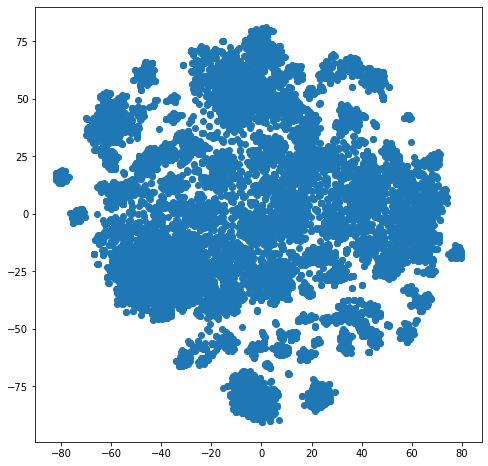

In [18]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
xs = list(map(lambda x: x[0], tsne_proj))
ys = list(map(lambda x: x[1], tsne_proj))
plt.scatter(xs, ys)

In [26]:
clip_model, _ = clip.load('ViT-B/16', device=device, jit=False)
clip_model.eval()

In [53]:
%%time
tsne = TSNE(2, verbose=0, random_state=42)

with torch.no_grad():
    text_embed = clip_model.encode_text(clip.tokenize(['A cat', 'A dog']).to(device))
    text_embed /= text_embed.norm(dim=-1, keepdim=True)
    all_embeds = torch.cat([images_features, text_embed])
    tsne_proj = tsne.fit_transform(all_embeds.cpu())

/home/lleonard/.cache/pypoetry/virtualenvs/photo-gallery-server-5hvlOb9K-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lleonard/.cache/pypoetry/virtualenvs/photo-gallery-server-5hvlOb9K-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 2min 35s, sys: 18.8 s, total: 2min 54s
Wall time: 36 s


In [57]:
text_embed

tensor([[ 0.0509, -0.0029,  0.0180,  ...,  0.0172,  0.0017,  0.0166],
        [ 0.0413, -0.0110,  0.0156,  ..., -0.0009,  0.0281,  0.0249]],
       device='cuda:0', dtype=torch.float16)

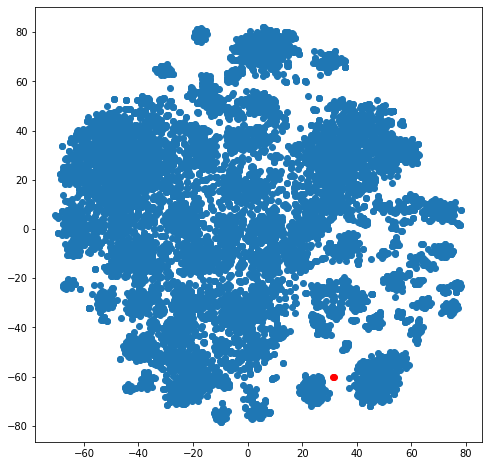

In [54]:
xs = list(map(lambda x: x[0], tsne_proj))
ys = list(map(lambda x: x[1], tsne_proj))
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(xs[:-2], ys[:-2])
ax.scatter(xs[-2:], ys[-2:], c='red')
plt.show()